In [1]:
import numpy as np
from scipy.signal import correlate
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_parquet("outputs/esri_tmin_tmax_pm25_wf_smokePM_fillna_pred_merged.parquet")

In [3]:
df.head()

tmax      tmin      pm25  FIREDAY_NONE_ZEROS  \
time       FIPS                                                        
2005-12-31 1765.0  13.350000  7.850000  4.986000                 NaN   
           1766.0  14.950006  8.249994  5.500000                 NaN   
           1767.0  14.950006  8.249994  5.486667                 NaN   
           1768.0  14.950006  8.249994  5.437778                 NaN   
           1769.0  14.950006  8.249994  5.480000                 NaN   

                   smokePM_pred  
time       FIPS                  
2005-12-31 1765.0           0.0  
           1766.0           0.0  
           1767.0           0.0  
           1768.0           0.0  
           1769.0           0.0

In [4]:
df = df.rename(columns={"FIREDAY_NONE_ZEROS":"wfday"}) # wildfire day - 1.0 if yes, 0.0 if no

In [5]:
df=df.reset_index()

## Select for FIPS with wildfires

In [6]:
df_total_wfday = df.groupby("FIPS")["wfday"].sum().reset_index(name ='total_wfdays')

In [7]:
df_total_wfday = df_total_wfday[df_total_wfday['total_wfdays'] > 0]

In [8]:
# take top 10 places
df_total_wfday=df_total_wfday.sort_values(by="total_wfdays", ascending=False)
df_total_wfday=df_total_wfday.head(10)

In [9]:
wfday_fips = list(df_total_wfday.FIPS)

In [10]:
len(df)

52543404

In [11]:
df = df.dropna()

In [12]:
df = df[df['FIPS'].isin(wfday_fips)]

In [13]:
len(df)

54610

In [14]:
df.head()

time    FIPS       tmax       tmin      pm25  wfday  smokePM_pred
11070 2006-01-01  3859.0  17.350000  10.149988  4.644000    0.0           0.0
11267 2006-01-01  4056.0  17.550013  11.149988  4.240000    0.0           0.0
11327 2006-01-01  4116.0  19.050013   9.050013  4.124444    0.0           0.0
13101 2006-01-01  5896.0  15.950006   7.149988  4.114286    0.0           0.0
15459 2006-01-01  8281.0  11.350000   3.350000  3.540000    0.0           0.0

In [15]:
events = ["tmax", 
          "tmin", "pm25", "wfday","smokePM_pred"]

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_74489/4031508615.py:22: RuntimeWarning: invalid value encountered in divide
  corr_range_normalized = corr_range / np.max(np.abs(corr_range))
/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_74489/4031508615.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3, 1, figsize=(8, 9))


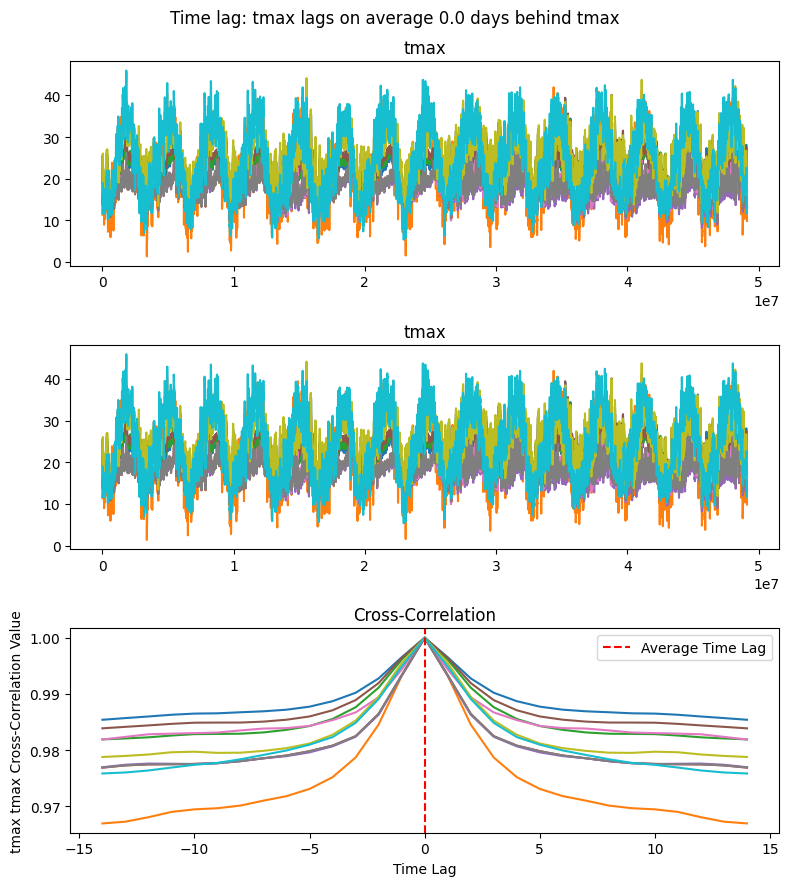

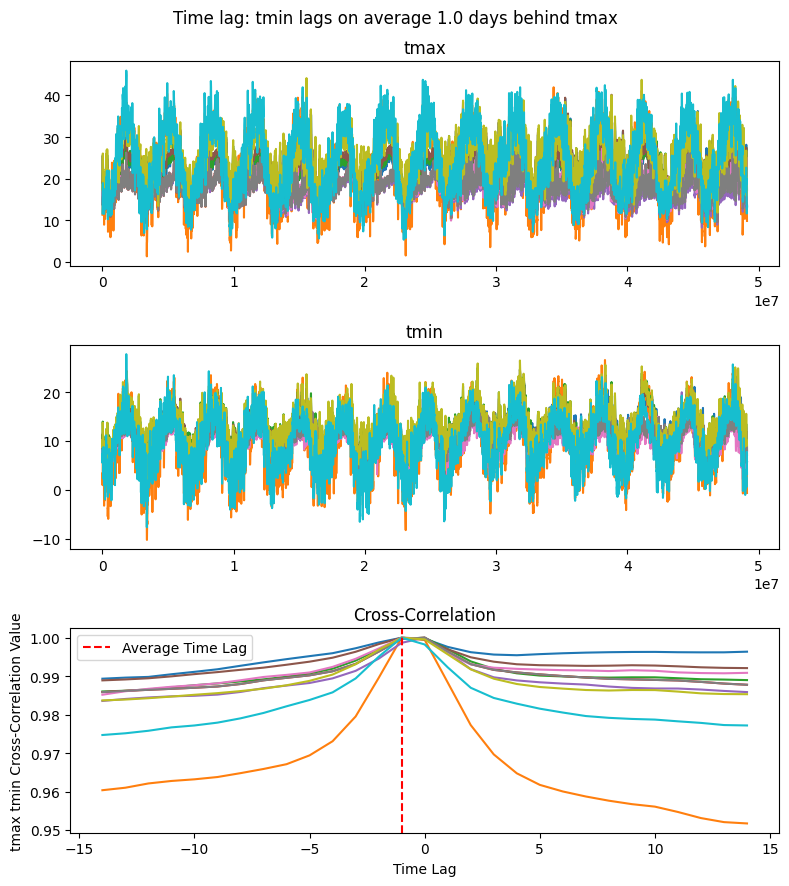

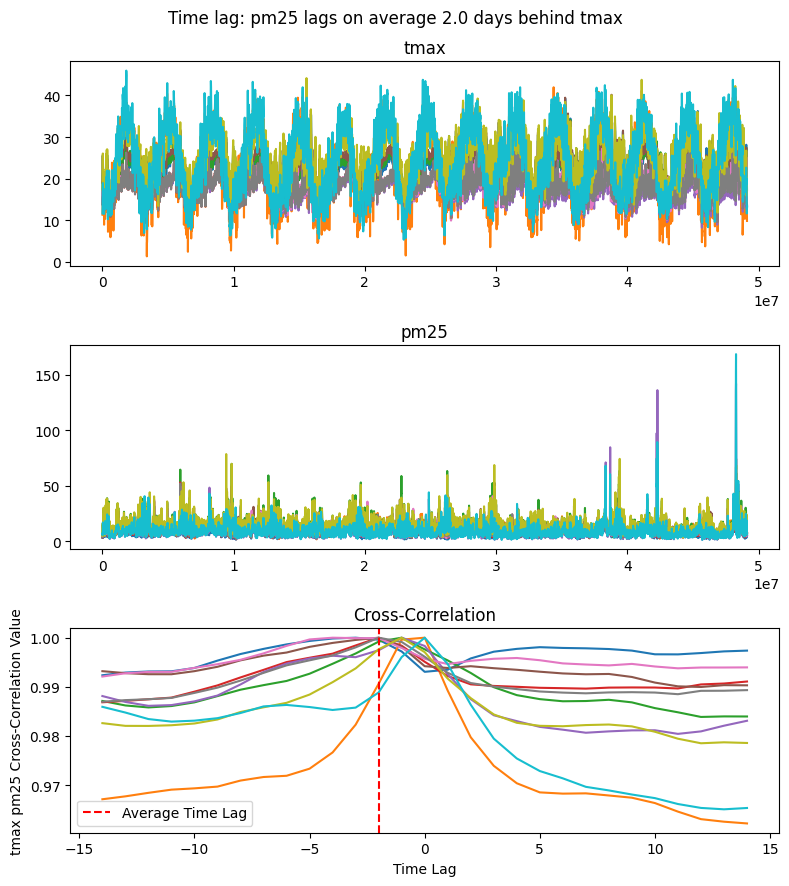

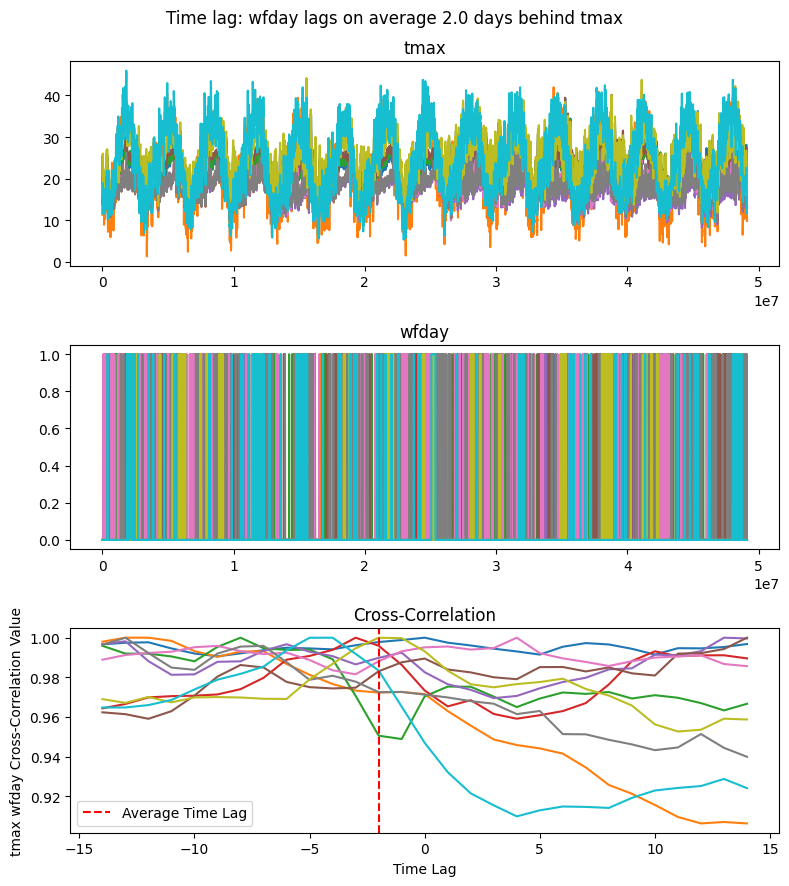

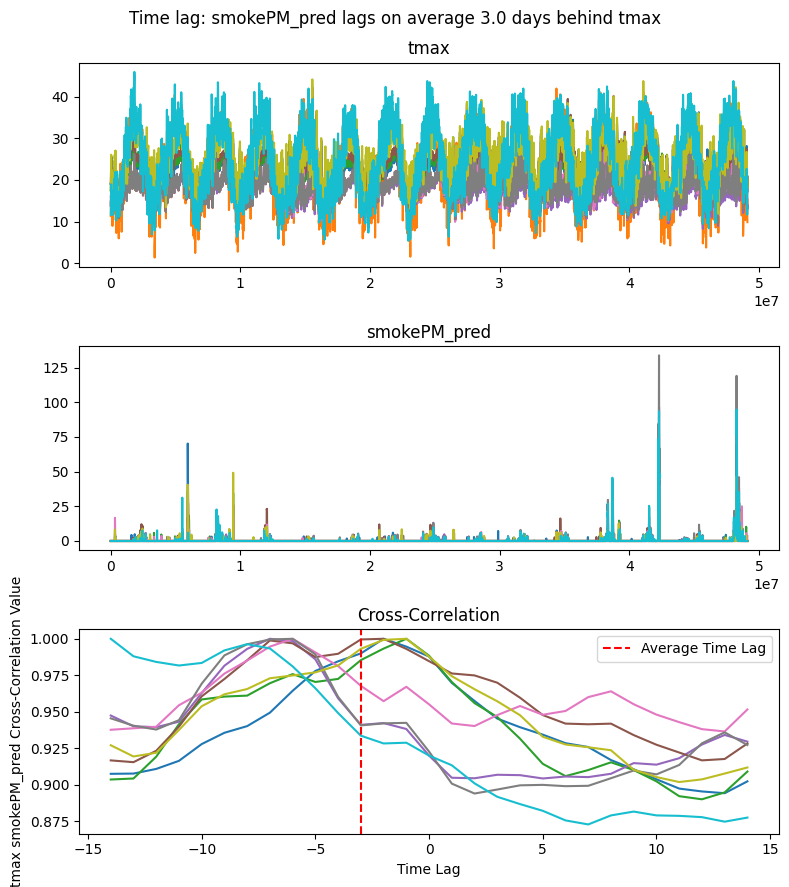

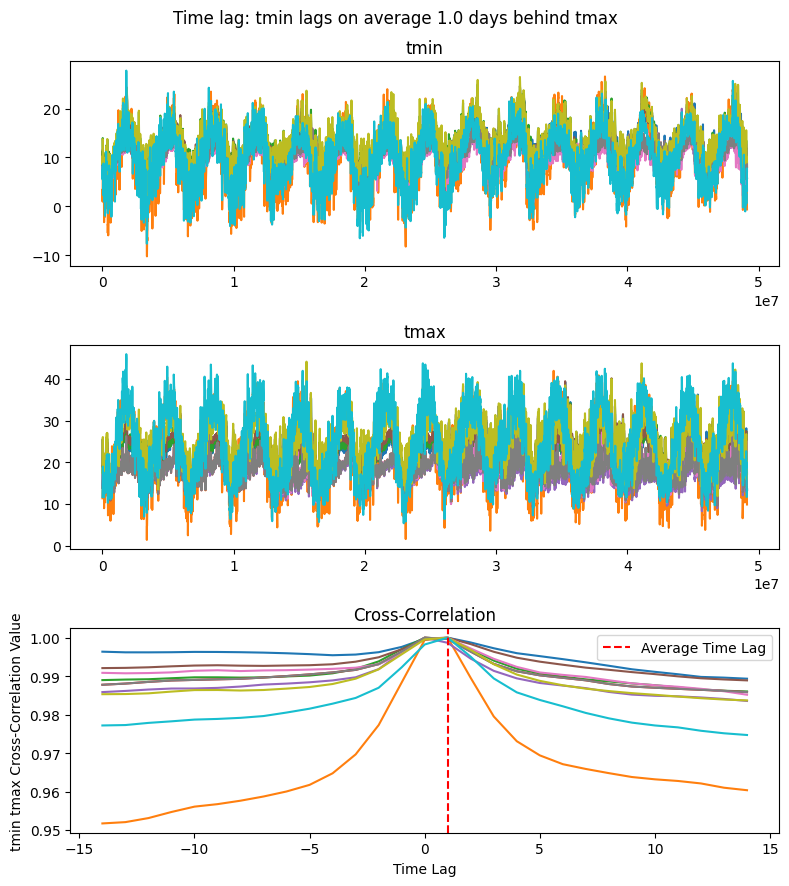

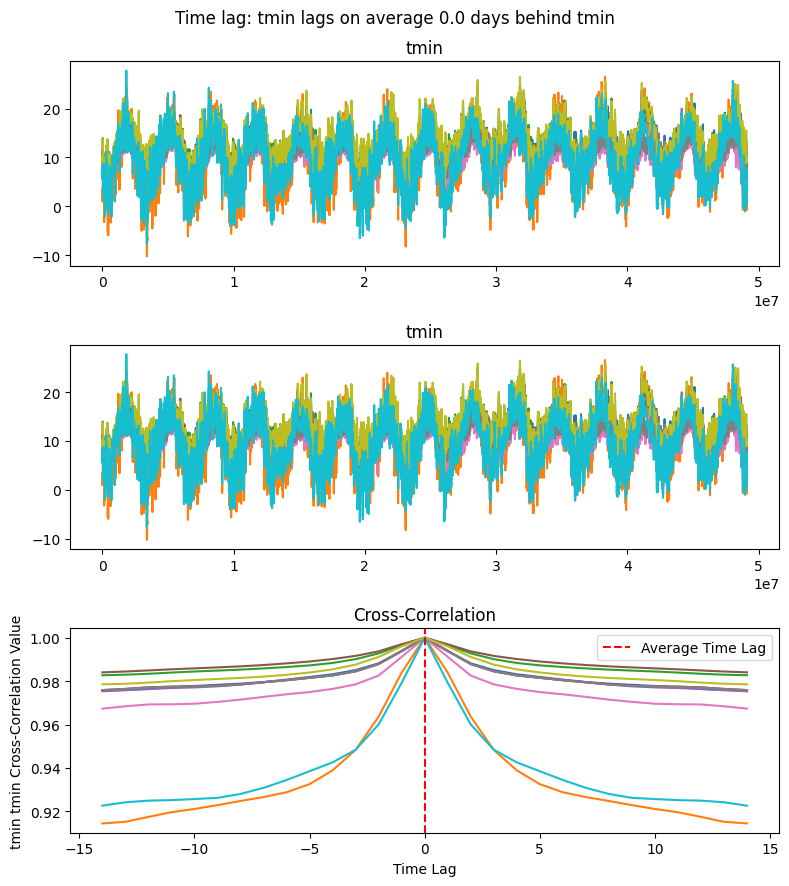

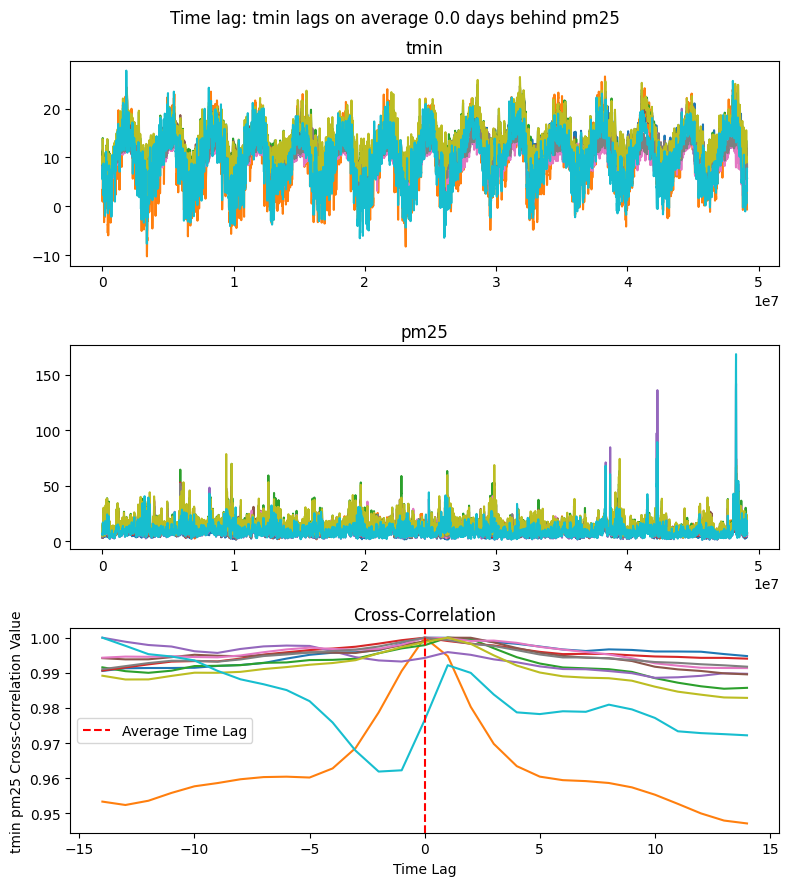

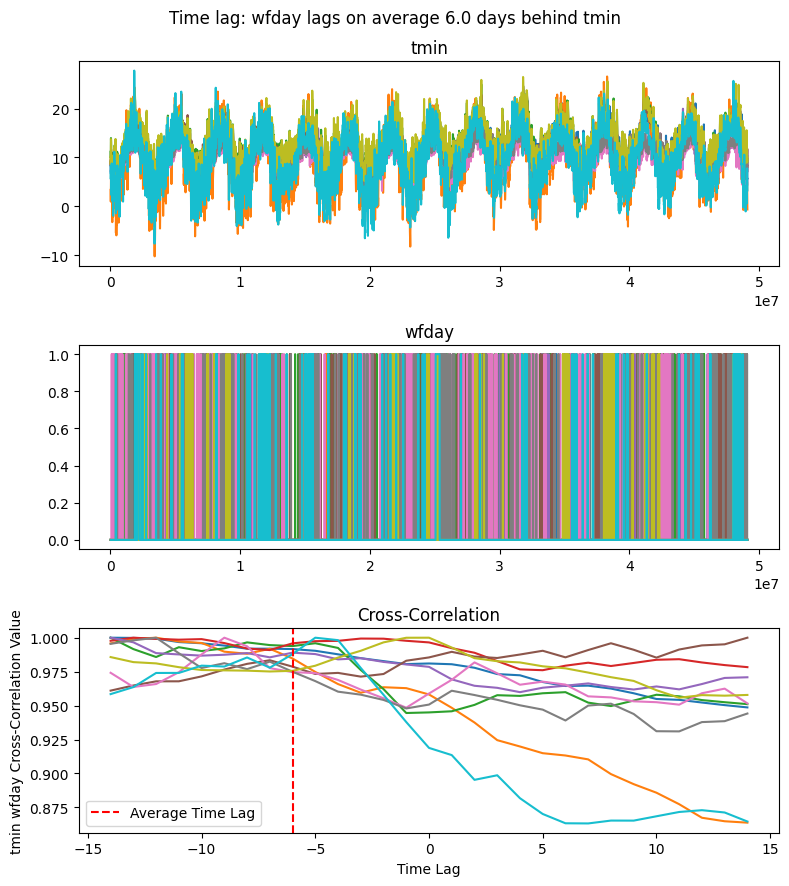

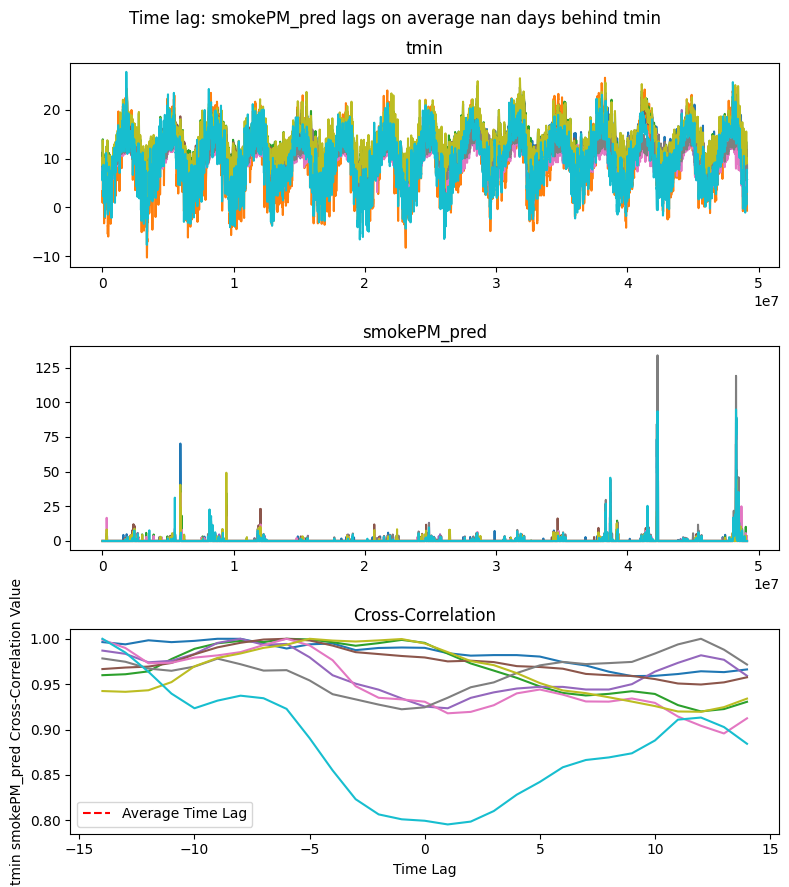

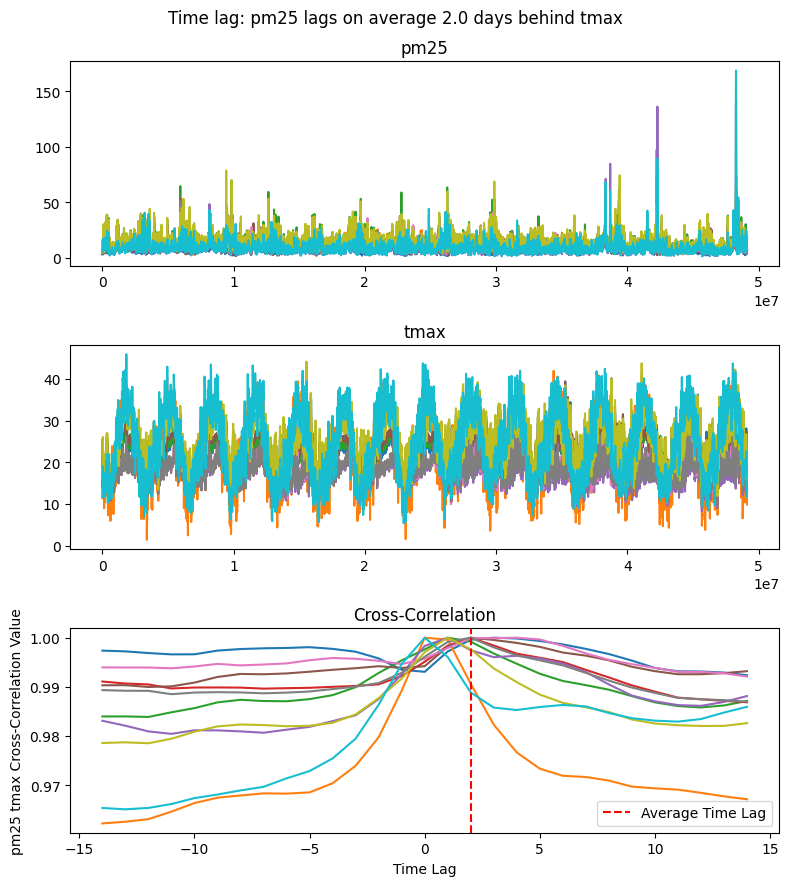

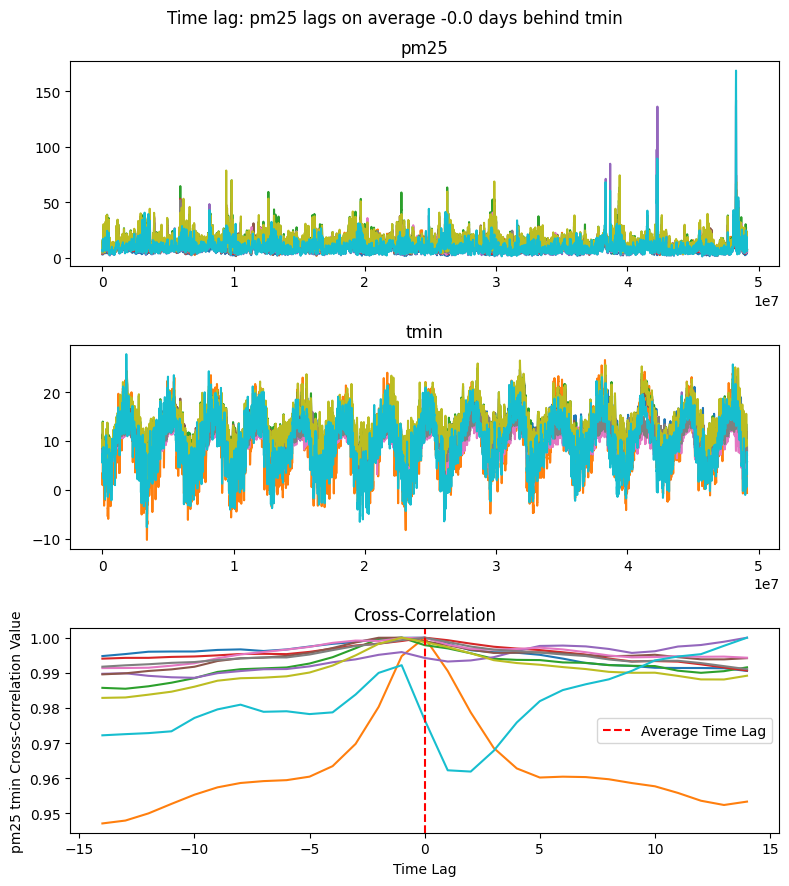

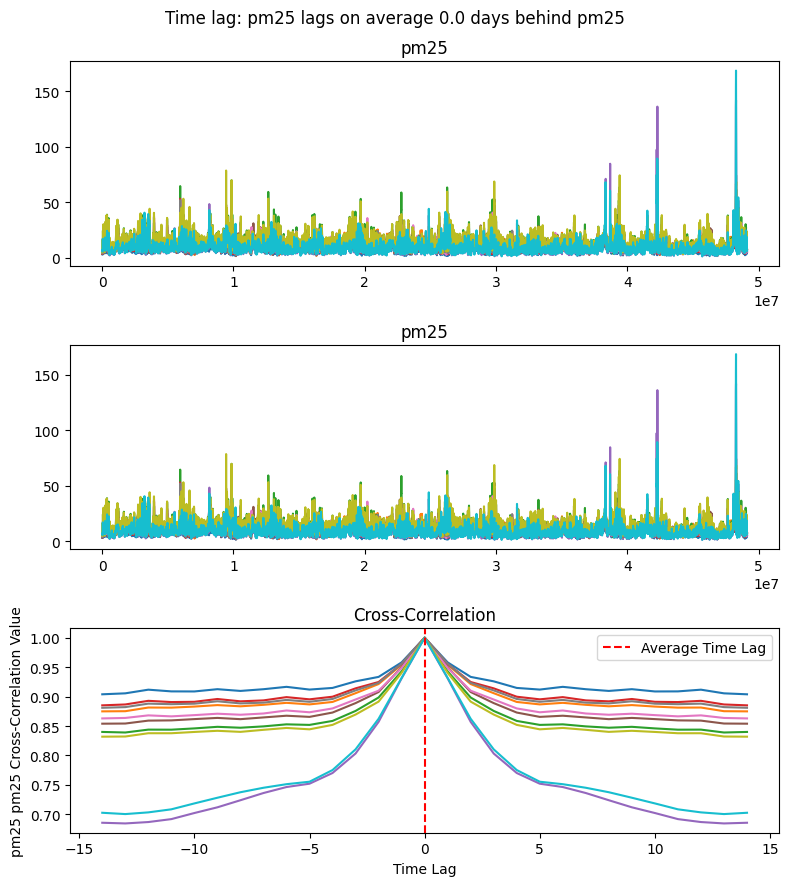

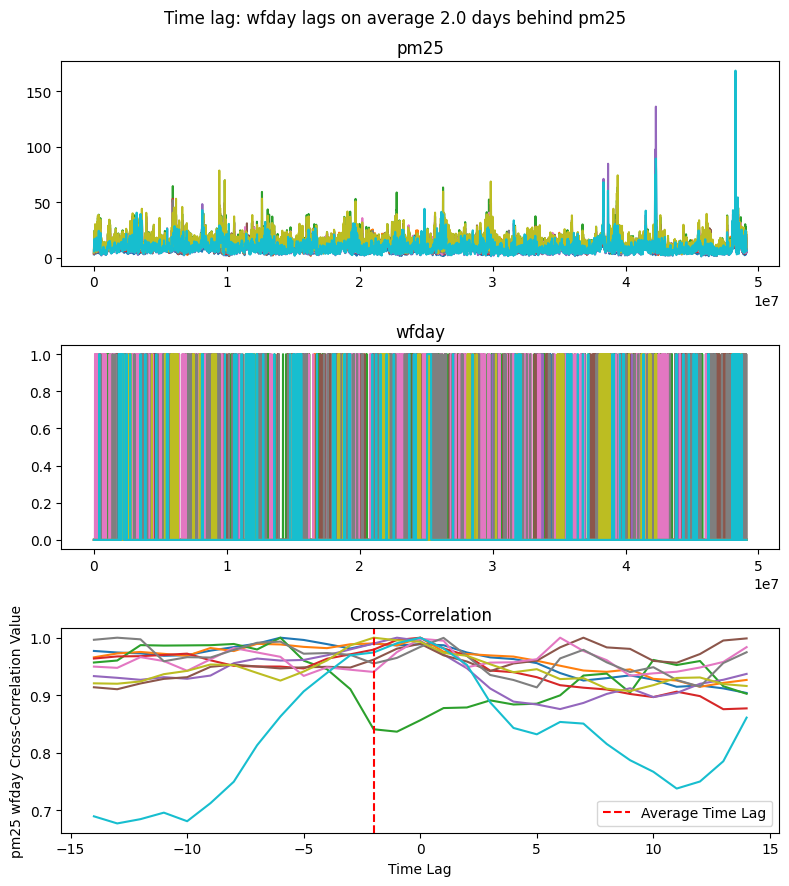

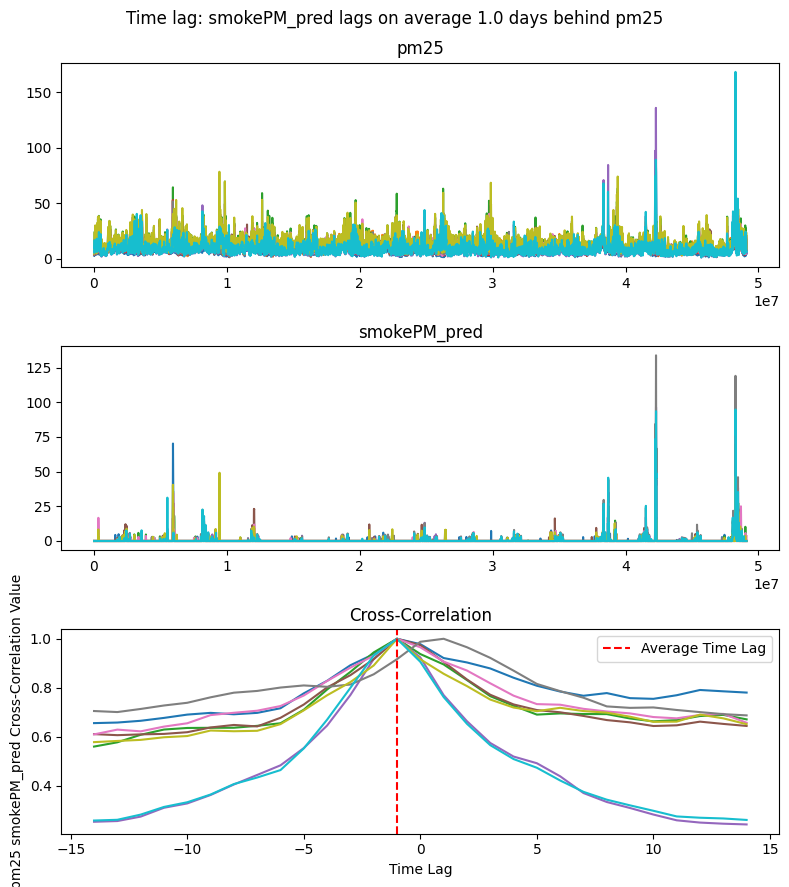

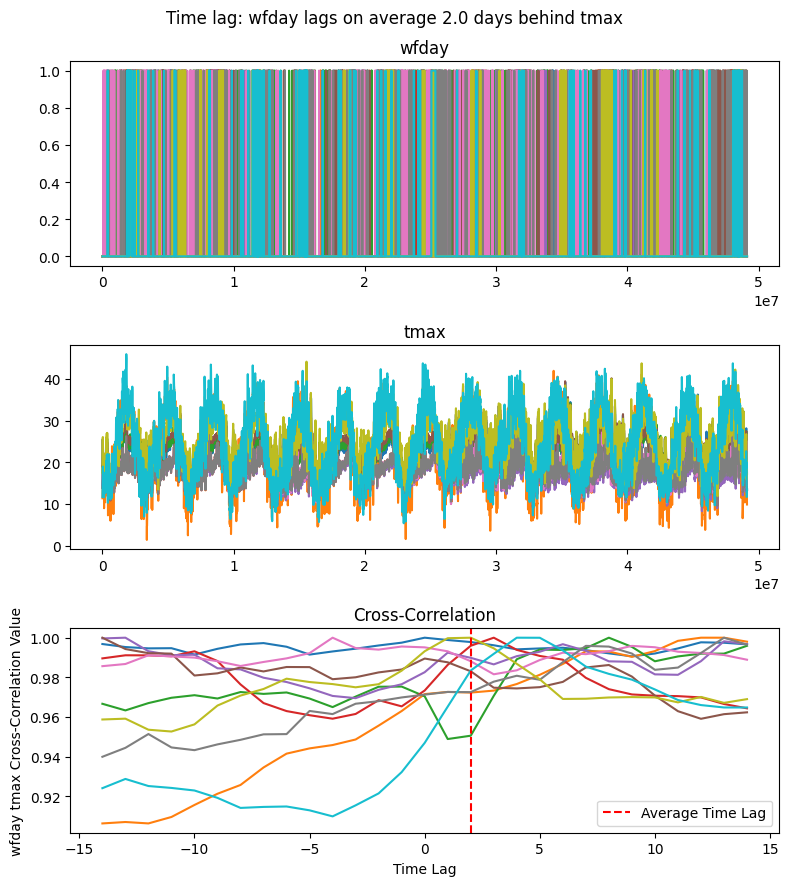

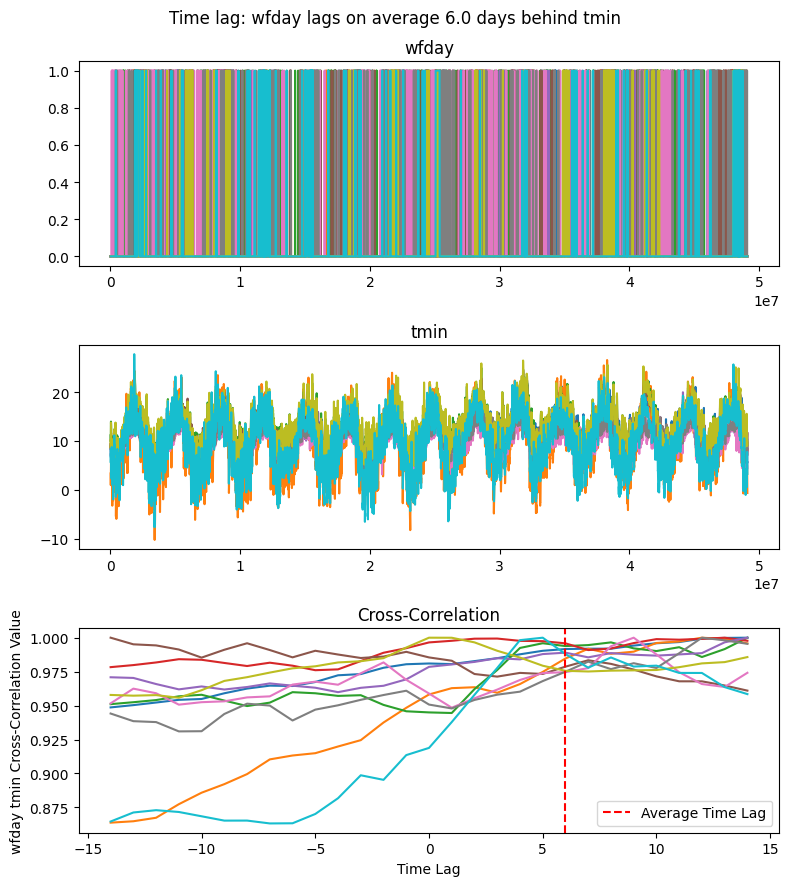

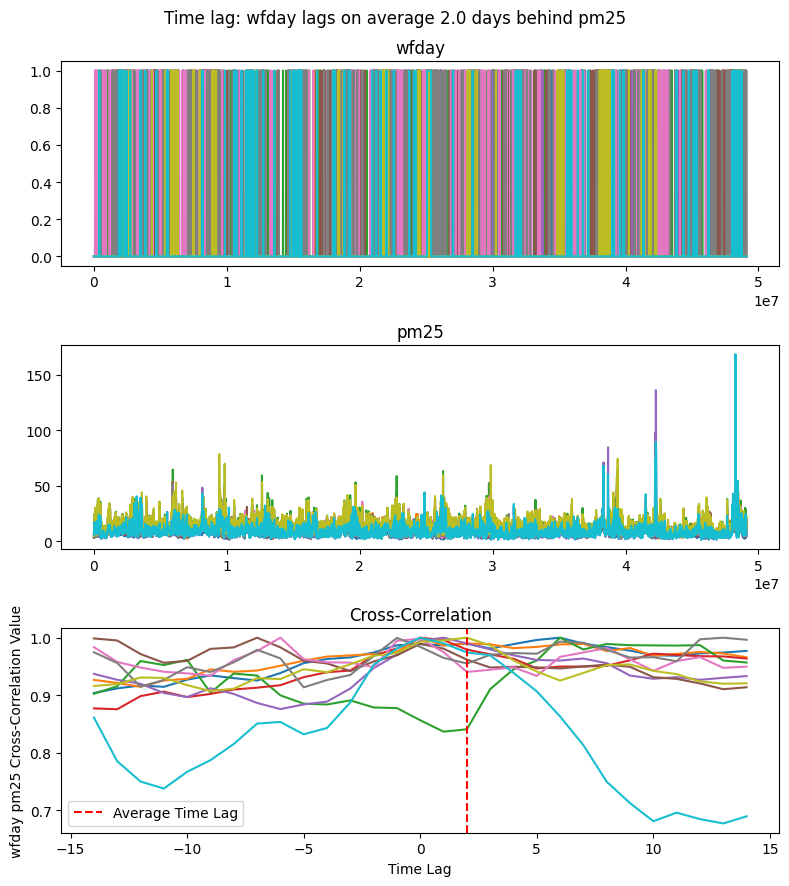

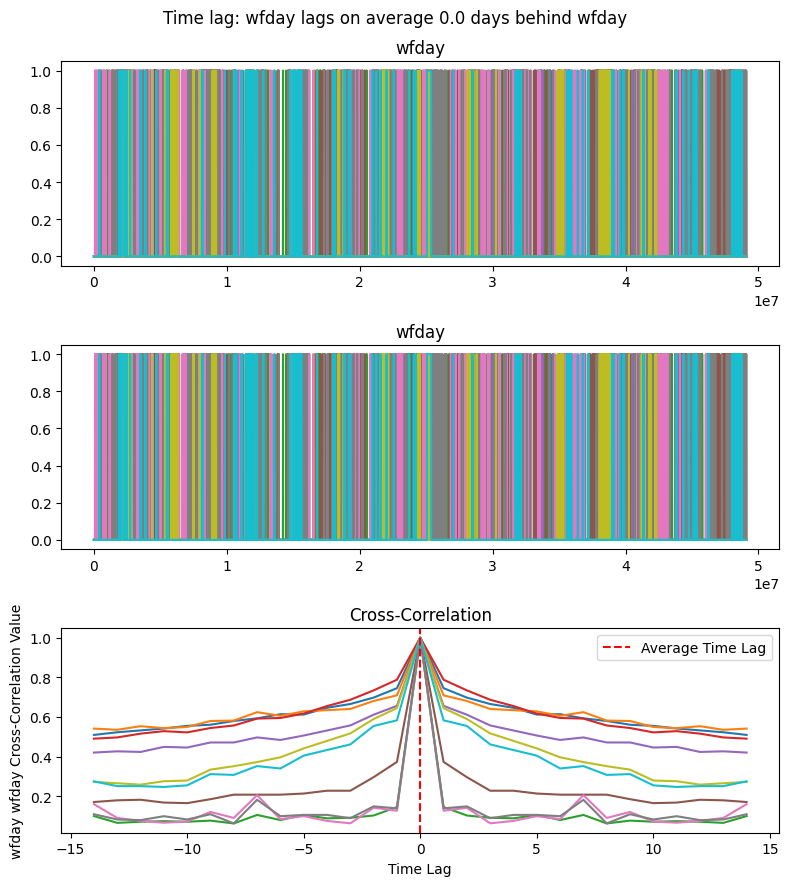

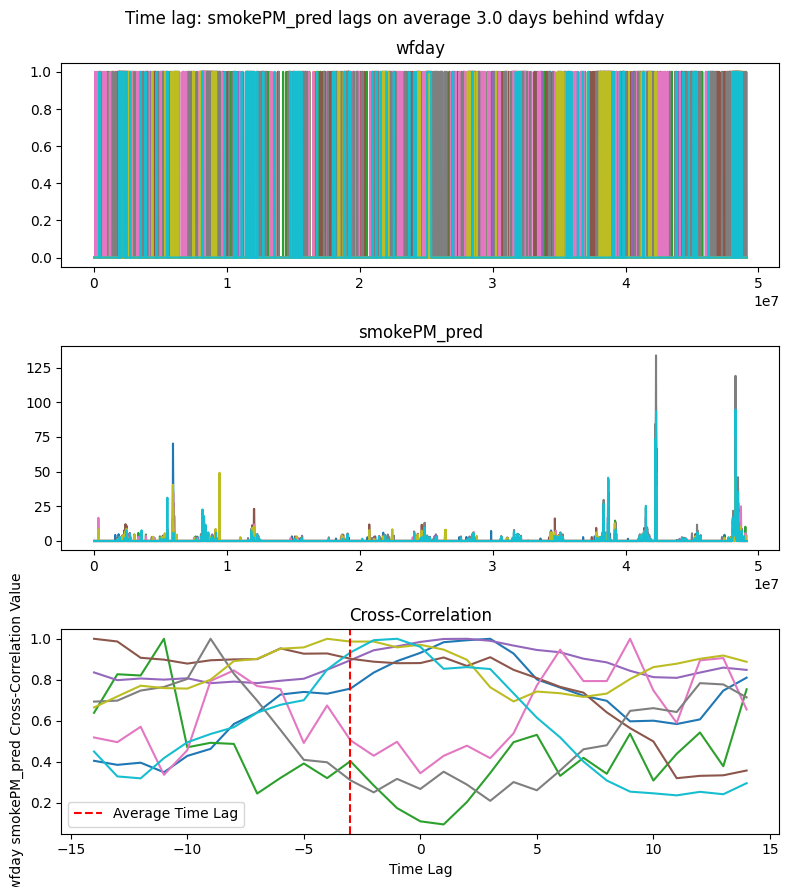

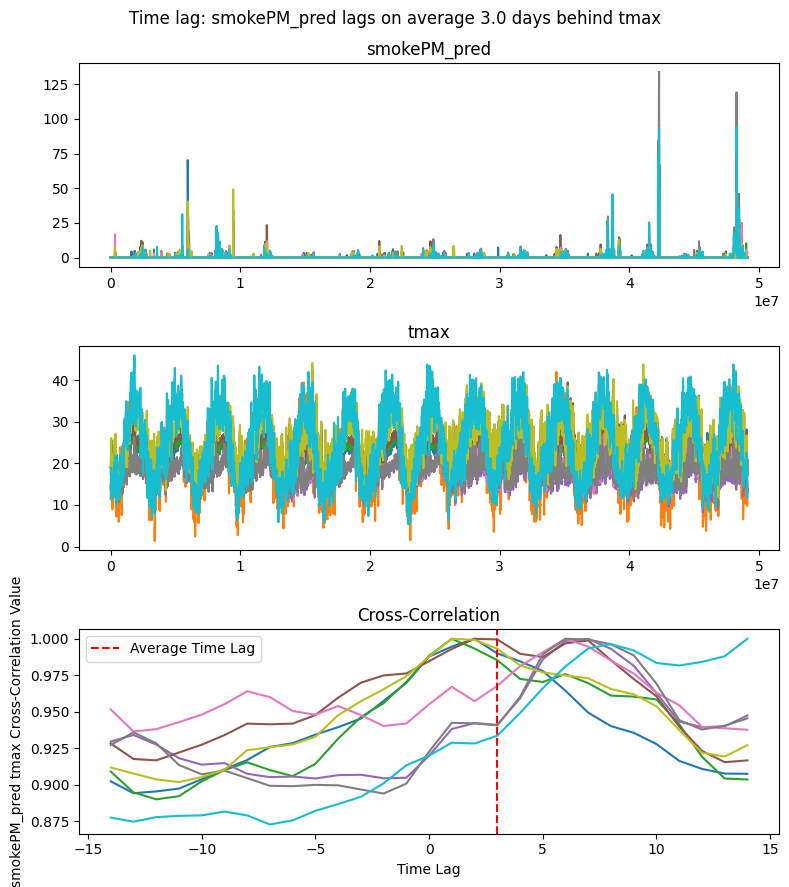

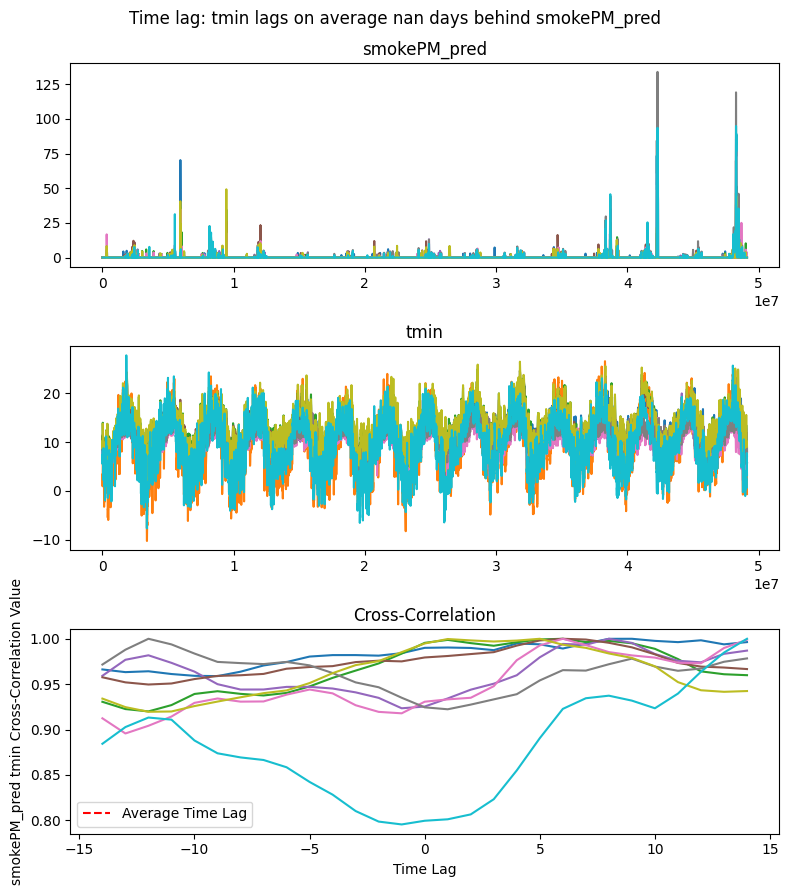

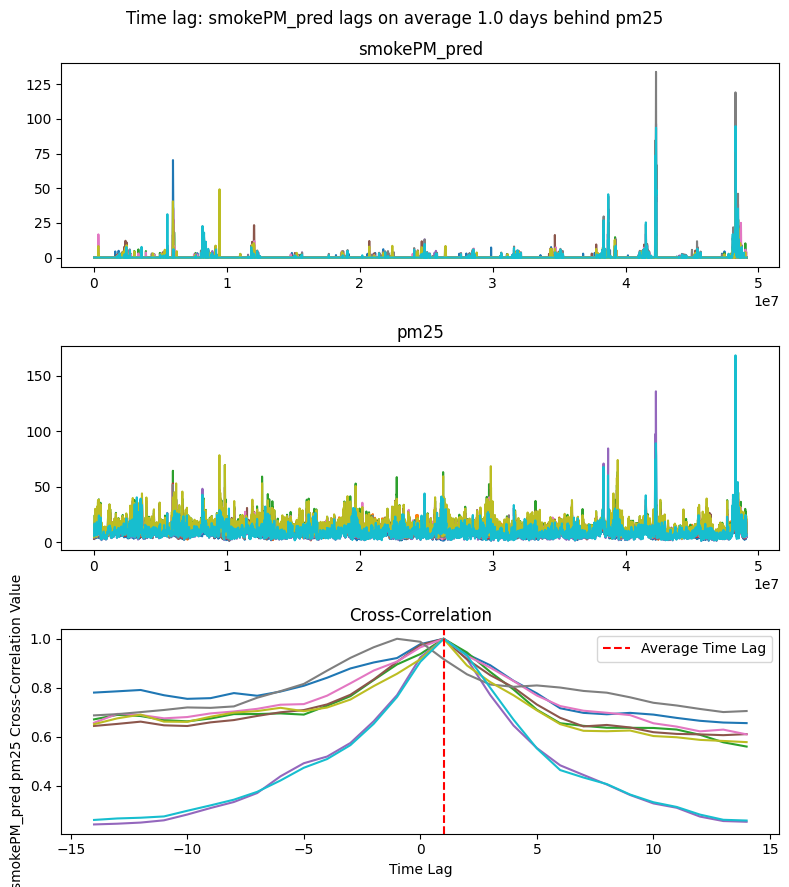

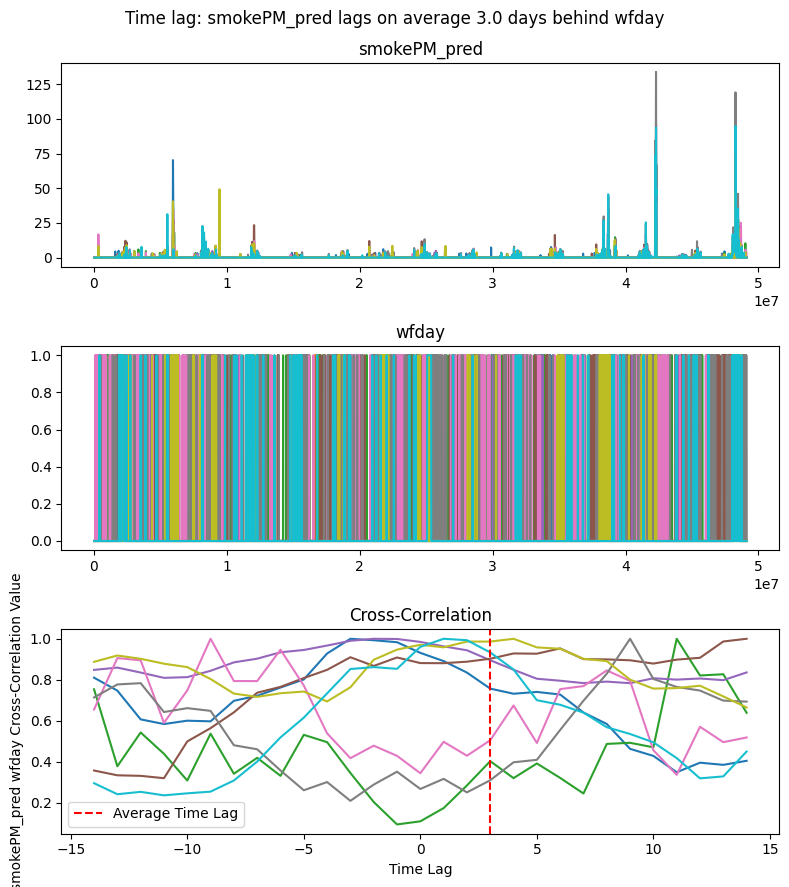

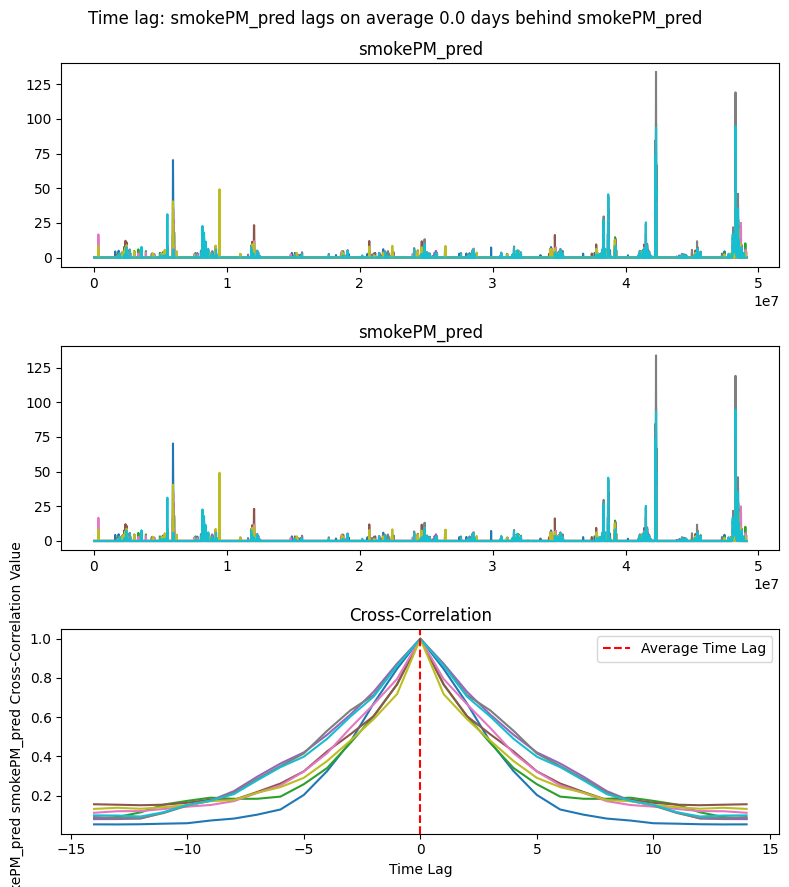

In [23]:
time_window = 14 #days
for e1 in events:
    for e2 in events:
        fig, ax = plt.subplots(3, 1, figsize=(8, 9))
        best_time_lag_list = []
        for fips in wfday_fips:
            var1 = df[df.FIPS == fips][e1]
            var2 = df[df.FIPS == fips][e2]
            
            ax[0].plot(var1)
            ax[0].set_title(e1)

            ax[1].plot(var2)
            ax[1].set_title(e2)
            
            # if time_lag is positive, var1 occured before var2
            corr = np.correlate(var1, var2, mode="full")
            
            time_lags = np.arange(-len(var1) + 1, len(var2))
            lag_range = np.logical_and(lags >= time_window*-1, lags <= time_window)
            corr_range = corr[lag_range]
            corr_range_normalized = corr_range / np.max(np.abs(corr_range))

            # plot the cross-correlation
            ax[2].plot(time_lags[lag_range], corr_range_normalized)

            # Find time lag with maximum cross-correlation
            best_time_lag = time_lags[np.argmax(corr)]
            best_time_lag_list.append(best_time_lag)
            
            ax[2].set_title('Cross-Correlation')
            ax[2].set_xlabel('Time Lag')
            ax[2].set_ylabel(e1+" "+e2+' Cross-Correlation Value')

        # Mark best time lag on the plot
        best_time_lag_list = [item for item in best_time_lag_list if item >= time_window*-1 and item <= time_window]
        
        btl = np.mean(best_time_lag_list).round()
        
        fig_title = "Time lag: {} lags on average {} days behind {}"
        if btl >= 0:
            fig_title=fig_title.format(e1, str(btl), e2)
        else:
            fig_title=fig_title.format(e2, str(np.abs(btl)), e1)
        fig.suptitle(fig_title)
        
        ax[2].axvline(btl, color='r', linestyle='--', label='Average Time Lag')
        ax[2].legend()
        
        fig.tight_layout()
        fig.savefig("figures/"+e1+"_"+e2+"_"+"cross-correlation.png")